In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import pandas as pd
from scipy.stats import kendalltau
from sklearn.metrics import ndcg_score
from tqdm import tqdm_notebook
import os
from typing import List

import sys
sys.path.append('../')
from common import Sphere, normalize
from fpme_utils import FairOracle, create_a_B_lamb_T
from fpme import FPME

In [3]:
def score_ranking(true_score: np.array, pred_score: np.array):
    '''
    Scores a true ranking against a predicting ranking using NDCG and Kentall Tau metrics.
    '''
    ndcg = ndcg_score([true_score], [pred_score], ignore_ties=True)
    kdtau, _ = kendalltau(true_score, pred_score)
    return ndcg, kdtau


def compute_costs(oracle: FairOracle, all_rate_lists: List[List[np.array]]) -> np.array:
    '''
    Computes the costs for each classifier using the extracted rate list from the classifier's
    confusion matrix.
    
    all_rate_lists should be as long as the number of classifiers we are ranking. Each entry
    should be a list of rate vectors for that classifier across `ng` groups.
    '''
    costs = []
    for rate_list in all_rate_lists:
        costs.append(oracle._score(rate_list))
    return np.array(costs)

def get_rates(df):
    """
    Gets the rate vector from a group's confusion matrix df. Recall rate vectors are
    P(predicted = j | actual = i, group = g). They are extracted from a group's confusion
    matrix using the off-diagonal elements. We will assume here that columns are ordered in
    a structured way, so that the end rate vector looks like this:
    [
        P(predicted = 1, actual = 0, group = g),
        P(predicted = 2, actual = 0, group = g),
        ...
        P(predicted = `nc` - 1, actual = 0, group = g)
        P(predicted = 0, actual = 1, group = g)
        P(predicted = 2, actual = 1, group = g)
        ...
    ]
    """
    off_diag_colums = []
    for c in df.columns:
        # we extract the row/col from the string name
        # ex: C_01 -> i = 0; j = 1
        i = int(c[2])
        j = int(c[3])
        if i != j:
            off_diag_colums.append(c)
    q = len(off_diag_colums)
    confusions = df[off_diag_colums].values
    return confusions

In [4]:
np.random.seed(7)

files = [
    [
        "data/fair/adult_fair_g1.csv",
        "data/fair/adult_fair_g2.csv",
    ],
    [
        "data/fair/default_fair_g1.csv",
        "data/fair/default_fair_g2.csv",
    ],
]

Ts = [
    np.array([
        [0.6132621523, 0.8486595057],
        [0.3867378477, 0.1513404943]
    ]),
    np.array([
        [0.3886783874, 0.4380321665],
        [0.6113216126, 0.5619678335]
    ]),
]

dataset_names = [
    "Adult_(k=2)",
    "Default_(k=2)"
]


colors = ["r", "g"]

linestyle_list = ['solid', 'dashed']

search_tol = 1e-2
trials = 100

In [5]:
# run trials across all datasets; runtime: few minutes, no multiprocessing
os.makedirs("trials/fpme/ranking/", exist_ok=True)
for i in range(2):
    dataset_files = files[i]
    dn = dataset_names[i]
    T = Ts[i]
    if os.path.exists(f"trials/fpme/ranking/{dn}_est_oracle_scores.npy"):
        print(f"did {dn}")
        continue
    
    rates = []
    for file in dataset_files:
        df_gi = pd.read_csv(file)
        rate_gi = get_rates(df_gi)
        rates.append(rate_gi)
    # the rate list for the cth classifier with be at all_rate_lists[c]
    all_rate_lists = []
    for c in range(len(rates[0])):
        rate_list = []
        for rate_gi in rates:
            rate_list.append(rate_gi[c])
        all_rate_lists.append(rate_list)
    
    ng = len(dataset_files)
    nc = int(np.sqrt(len(df_gi.columns)))
    q = nc ** 2 - nc
    assert q == rates[0].shape[1]
    
    # -- these are used to construct the linear and accuracy oracles respectively --
    # each B[i][j] is just a matrix of 0s, meaning all misclassification costs are ignored
    ignore_B = [
        [np.matrix(np.zeros((q,q))) for _ in range(ng)]
        for _ in range(ng)
    ]

    # each B[i][j] is a matrix of some constant value, meaning any misclassification has the same cost
    num_matrices = ng * (ng - 1) // 2
    equalized_odds_B = [[np.matrix(np.zeros((q, q))) for j in range(ng)] for i in range(ng)]
    for i in range(ng):
        for j in range(i + 1, ng):
            equalized_odds_B[i][j] = normalize(np.matrix(np.ones((q,q))), to=2.0/num_matrices)
            equalized_odds_B[j][i] = equalized_odds_B[i][j]
    # ----
    
    # list of ndcg scores and kendall-tau scores
    est_oracle_scores = [[], []]
    linear_oracle_scores = [[], []]
    accuracy_oracle_scores = [[], []]
    
    sphere = Sphere(np.zeros(q), 1.0, q)
    for _ in tqdm_notebook(range(trials)):
        # we could save these to disk, but nah
        a, B, lamb, T = create_a_B_lamb_T(sphere, ng, nc, q, well_formed=True, T=T)
        true_oracle = FairOracle(a, B, lamb, T)
        fpm = FPME(sphere, true_oracle, T, nc, q, ng, search_tol, well_formed=True)
        a_hat, B_hat, lamb_hat = fpm.run_fpme()
        
        # the estimated oracle
        est_oracle = FairOracle(a_hat, B_hat, lamb_hat, T)
        
        # the linear oracle just uses the true a. lamb=0 because we do not care about fairness.
        linear_oracle = FairOracle(a, ignore_B, 0.0, T)

        # accuracy oracle will be 1's everywhere for the performance metric a because everything is off-diag
        # (lesser the score, the better). Quadratic costs are all equalized so any misclassification is
        # equally penalized across groups. lamb=0.5 as performance and fairness are equally considered.
        acc_oracle = FairOracle(normalize(np.ones(q), to=1.0), equalized_odds_B, 0.5, T)
            
        true_costs = compute_costs(true_oracle, all_rate_lists)
        est_costs = compute_costs(est_oracle, all_rate_lists)
        linear_costs = compute_costs(linear_oracle, all_rate_lists)
        acc_costs = compute_costs(acc_oracle, all_rate_lists)
        
        # we need to pass score such that higher cost = better; we have been working
        # with cost (lower is better) thus far
        true_score = (1.0 / true_costs)
        est_score = (1.0 / est_costs)
        linear_score = (1.0 / linear_costs)
        acc_score = (1.0 / acc_costs)
        
        # ers = est rank score, lrs = linear rank score, ars = accuracy rank score
        # each is a tuple of (ndcg_score, kendalltau_score)
        ers = score_ranking(true_score, est_score)
        lrs = score_ranking(true_score, linear_score)
        ars = score_ranking(true_score, acc_score)

        est_oracle_scores[0].append(ers[0])
        est_oracle_scores[1].append(ers[1])

        linear_oracle_scores[0].append(lrs[0])
        linear_oracle_scores[1].append(lrs[1])

        accuracy_oracle_scores[0].append(ars[0])
        accuracy_oracle_scores[1].append(ars[1])
                
    est_oracle_scores = np.array(est_oracle_scores)
    linear_oracle_scores = np.array(linear_oracle_scores)
    accuracy_oracle_scores = np.array(accuracy_oracle_scores)
    
    os.makedirs('trials/fpme/ranking/', exist_ok=True)
    np.save(f'trials/fpme/ranking/{dn}_est_oracle_scores.npy', est_oracle_scores)
    np.save(f'trials/fpme/ranking/{dn}_linear_oracle_scores.npy', linear_oracle_scores)
    np.save(f'trials/fpme/ranking/{dn}_accuracy_oracle_scores.npy', accuracy_oracle_scores)

In [6]:
# idx 0: adult
# idx 1: default
# each idx has a tuple (estimated_oracle_score, linear_oracle_score, accuracy_oracle_score)
# each type of score is a tuple (ndcg, kendalltau)
# ex: results[0][0][1] gives all trial results for adult dataset, estimated oracle scores, kendalltau metric
# ex: results[1][1][0] gives all trial results for default dataset, linear oracle scores, ndcg metric
results = []

for dn in dataset_names:
    eos = np.load(f'trials/fpme/ranking/{dn}_est_oracle_scores.npy')
    los = np.load(f'trials/fpme/ranking/{dn}_linear_oracle_scores.npy')
    aos = np.load(f'trials/fpme/ranking/{dn}_accuracy_oracle_scores.npy')
    
    results.append((eos, los, aos))

In [20]:
for i in range(2):
    stringi = {0: "adult", 1: "default"}[i]
    for j in range(3):
        stringj = {0: "estimated_oracle", 1: "linear_oracle", 2: "accuracy_oracle"}[j]
        print(stringi, stringj, "NDCG:", np.median(results[i][j][0]), "KDTAU:", np.median(results[i][j][1]))
    print()

adult estimated_oracle NDCG: 0.9999994167234161 KDTAU: 0.9971518987341771
adult linear_oracle NDCG: 0.9875016718652285 KDTAU: 0.5917721518987341
adult accuracy_oracle NDCG: 0.9857491769864279 KDTAU: 0.37626582278481013

default estimated_oracle NDCG: 0.9999998961411679 KDTAU: 0.9981012658227848
default linear_oracle NDCG: 0.9993751953628578 KDTAU: 0.9056962025316455
default accuracy_oracle NDCG: 0.9889343352083111 KDTAU: 0.495253164556962



In [12]:
results[0][0][0]

array([0.99999767, 0.99999866, 0.99999907, 0.99999991, 0.99998353,
       0.99995666, 0.99999965, 0.99999613, 0.99998489, 0.99999799,
       0.99999996, 0.99999993, 0.99999936, 0.99999717, 1.        ,
       0.99999856, 0.99999806, 0.99999556, 0.99999962, 0.9999857 ,
       0.99999234, 0.99999576, 1.        , 1.        , 0.99999985,
       0.99999992, 1.        , 0.99999852, 0.99999169, 0.99999988,
       0.99999959, 0.99999981, 0.99999664, 1.        , 1.        ,
       0.99999723, 0.99999922, 0.99999414, 0.99999912, 0.99999465,
       0.99999943, 0.99999999, 0.9999998 , 0.99999986, 0.99999974,
       0.99999959, 0.99999999, 0.9999931 , 0.99997288, 0.99999785,
       0.99999721, 0.99998965, 0.99996626, 1.        , 0.99999789,
       0.99999664, 0.9999571 , 0.99999841, 0.99999988, 0.99999588,
       0.99999472, 1.        , 0.99999999, 0.99999996, 0.9999994 ,
       0.9999995 , 0.99990043, 0.99999997, 0.99999976, 0.99999998,
       0.99997222, 0.99999876, 0.99998459, 0.9999997 , 0.99999

In [11]:
results

[(array([[0.99999767, 0.99999866, 0.99999907, 0.99999991, 0.99998353,
          0.99995666, 0.99999965, 0.99999613, 0.99998489, 0.99999799,
          0.99999996, 0.99999993, 0.99999936, 0.99999717, 1.        ,
          0.99999856, 0.99999806, 0.99999556, 0.99999962, 0.9999857 ,
          0.99999234, 0.99999576, 1.        , 1.        , 0.99999985,
          0.99999992, 1.        , 0.99999852, 0.99999169, 0.99999988,
          0.99999959, 0.99999981, 0.99999664, 1.        , 1.        ,
          0.99999723, 0.99999922, 0.99999414, 0.99999912, 0.99999465,
          0.99999943, 0.99999999, 0.9999998 , 0.99999986, 0.99999974,
          0.99999959, 0.99999999, 0.9999931 , 0.99997288, 0.99999785,
          0.99999721, 0.99998965, 0.99996626, 1.        , 0.99999789,
          0.99999664, 0.9999571 , 0.99999841, 0.99999988, 0.99999588,
          0.99999472, 1.        , 0.99999999, 0.99999996, 0.9999994 ,
          0.9999995 , 0.99990043, 0.99999997, 0.99999976, 0.99999998,
          0.99997222

In [7]:
def plot_general(m):
    '''
    m: 0 for estimated scores, 1 for linear scores, 2 for accuracy scores
    '''
    plt.figure(figsize=(8,5))
    
    x = [1, 2, 3]

    for i in range(len(dataset_names)):
        eos, los, aos = results[i]
        dn = dataset_names[i]
        
        plt.plot(
            x,
            [ np.median(eos[m,:]), np.median(los[m,:]), np.median(aos[m,:]) ],
            color = colors[i],
            linestyle = linestyle_list[i],
            linewidth = 3,
            label = dn,
        )    
        
    fontP = FontProperties()
    fontP.set_size(15)
    plt.legend(prop = fontP, loc = 'lower left')
    plt.xticks(x, ["elicited", "linear w/ no fairness", "accuracy w/ eq. odds"], weight='bold', fontsize=15)
        
def plot_ndcg():
    m = 0
    plot_general(m)

    plt.ylabel('NDCG',  fontsize = 15, weight = 'bold')

    plt.title('Classifier Ranking Evaluation - NDCG', fontsize = 18, weight = 'bold')
    plt.savefig('./plots/fpme/rank_ndcg.png', format = "png", bbox_inches = "tight")
    plt.show()
    
    
def plot_kendalltau():
    m = 1
    plot_general(m)
    
    plt.ylabel('KDTAU',  fontsize = 15, weight = 'bold')

    plt.title('Classifier Ranking Evaluation - KDTAU', fontsize = 18, weight = 'bold')
    plt.savefig('./plots/fpme/rank_kdtau.png', format = "png", bbox_inches = "tight")
    plt.show()

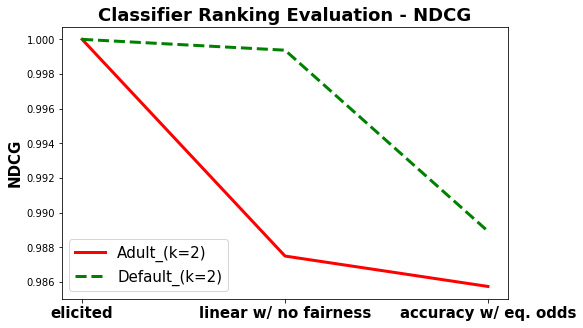

In [8]:
plot_ndcg()

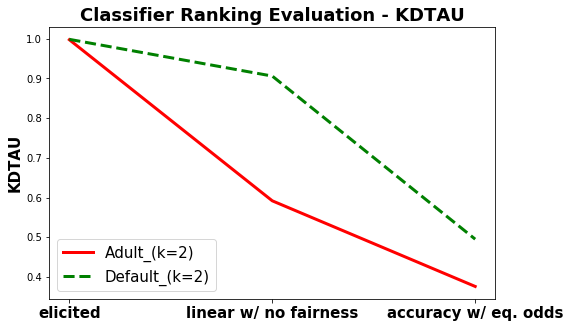

In [9]:
plot_kendalltau()